# Carrier Concentration under AM1.5G Solar Spectrum

The carrier concentration of a material under the AM1.5G solar spectrum can be
calculated from its optical absorption. The overall equation here is:

$$\Delta n = G \tau$$

where $\Delta n$ is the excess carrier density due to photoexcitation (in carriers/cm$^{-3}$), $G$ is the carrier
generation rate (in carriers/cm$^{-3}$s), and $\tau$ is the excited carrier lifetime (in s).

The theory on calculating the generation rate of carriers can be found here: http://www.pveducation.org/pvcdrom/generation-rate
 and here: http://www.pveducation.org/pvcdrom/collection-probability
 
To summarise, carrier generation can be calculated as:

$$ G = \alpha N_0 e^{-\alpha x}$$

Where $\alpha$ is the optical absorption coefficient (in cm$^{-1}$), $N_0$ is the photon flux at the surface (in photons/cm$^{-2}$s$^{-1}$nm), and $x$ is the depth into the device where generation is being measured (in cm). Both $\alpha$ and $N_0$ are dependent on the wavelength of the photons ($\lambda$), therefore we must integrate the generation rate across all wavelengths of interest:

$$\int \alpha (\lambda) N_0 (\lambda) e^{-\alpha  (\lambda) x} d\lambda$$

Lastly, we want to a calculate our carrier concentration for a specific thickness of device $W$ (in cm):

$$\int_0^W \int \alpha (\lambda) N_0 (\lambda) e^{-\alpha  (\lambda) x} d\lambda dx$$

NOTE: We are using a collection probability of 1, meaning that every incident photo is converted directly into a charge carrier. In reality this is a big simplification.

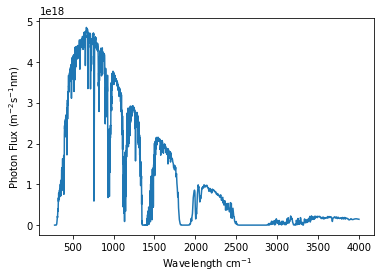

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from pvpy.PowerSpectrum import PhotonSpectrum

ps = PhotonSpectrum()
flux_spectrum = ps.get_spectrum()

plt.plot(flux_spectrum[0,:], flux_spectrum[1,:])
plt.gca().set(xlabel=r'Wavelength cm$^{-1}$', ylabel=r'Photon Flux (m$^{-2}$s$^{-1}$nm)')
plt.show()

In [2]:
import numpy as np
from scipy import interpolate
from scipy.constants import physical_constants

hv = physical_constants['Planck constant in eV s'][0] * \
     physical_constants['speed of light in vacuum'] [0]

def get_conc(energies, absorption, wavelength_limits=(280, 2000), thickness=2e-5, 
             delta_wavelength=5, delta_thickness=1e-7, carrier_lifetime=1e-5):
    """Calculate the carrier concentration of a material based on its absorption.
    
    Args:
        energies (np.array): Photon energies in eV
        absorption (np.array): Optical absorption in cm^-1
        wavelength_limits (tuple): Integration limits for the photon wavelengths
            as (min, max), in cm^-1.
        thickness (float): Thickness of material in cm
        delta_wavelength (float): Wavelength integration step size
        delta_thickness (float): Thickness integraton step size
        carrier_lifetime (float): Carrier lifetime of excited carriers
        
    Returns:
        Carrier concentration in cm^-3.
    """
    ps = PhotonSpectrum()
    flux_spectrum = ps.get_spectrum()

    # convert spectrum from m^-2 s^-1 nm to cm^-2 s^-1 nm and interpolate
    flux = interpolate.interp1d(flux_spectrum[0,:], flux_spectrum[1,:] * 1e-4)
    
    # convert energies to cm^-1 and interpolate absorption
    alpha = interpolate.interp1d(hv * 1e9 / energies, absorption)

    # widths and wavelengths over which to integrate
    widths = np.arange(0, thickness, delta_thickness)
    wavelengths = np.arange(wavelength_limits[0], wavelength_limits[1], delta_wavelength)

    gen_total = 0
    for w in widths:
        exps = np.exp(-alpha(wavelengths) * w)
        gen_total += np.sum(alpha(wavelengths) * flux(wavelengths) * exps) * delta_wavelength
    gen_total = gen_total * delta_thickness
    
    return(gen_total * carrier_lifetime)

In [3]:
bsi = np.loadtxt('bsi_rt_abs.dat', unpack=True)
bsei = np.loadtxt('bsei_rt_abs.dat', unpack=True)

print('BiSI conc = {:.3e} cm^-3'.format(get_conc(bsi[0,:], bsi[1,:])))
print('BiSeI conc = {:.3e} cm^-3'.format(get_conc(bsei[0,:], bsei[1,:])))

%timeit get_conc(bsi[0,:], bsi[1,:])

BiSI conc = 9.488e+11 cm^-3
BiSeI conc = 1.262e+12 cm^-3
20.6 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
